# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scrnatools as rna
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.grid"] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

## Set up file paths

### demeter

In [5]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [6]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Import data

In [7]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs.h5ad")

# Differential Density

## Fezf2 KO

In [8]:
adata = rna.tl.log_density_ratio(
    adata,
    group_by="genotype",
    groups=["WT", "Fezf2_KO"],
    key_added="Fezf2_KO/WT_genotype_density",
    latent_rep="X_umap",
)

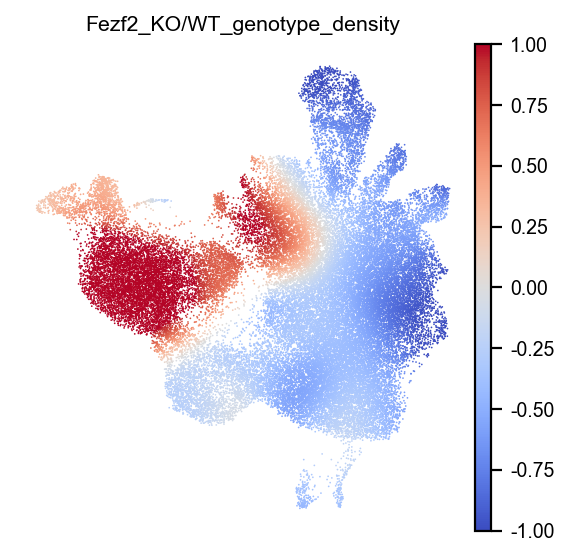

In [9]:
sc.settings.figdir = "../analysis/paper_figures/1/"
sc.pl.umap(
    adata,
    color="Fezf2_KO/WT_genotype_density",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    save="_1D_Fezf2_KO_density.pdf"
)

## Aire KO

In [10]:
adata = rna.tl.log_density_ratio(
    adata,
    group_by="genotype",
    groups=["WT", "Aire_KO"],
    key_added="Aire_KO/WT_genotype_density",
    latent_rep="X_umap",
)

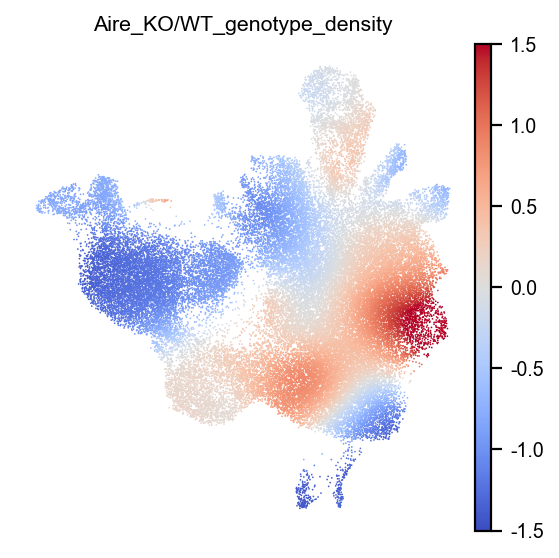

In [11]:
sc.settings.figdir = "../analysis/paper_figures/1/"
sc.pl.umap(
    adata,
    color="Aire_KO/WT_genotype_density",
    cmap="coolwarm",
    vmin=-1.5,
    vmax=1.5,
    save="_1D_Aire_KO_density.pdf"
)

# Cell type abundance

In [12]:
abundance_data = pd.DataFrame()
for genotype in adata.obs.genotype.unique():
    genotype_data = adata[adata.obs.genotype == genotype]
    for sample in genotype_data.obs["sample"].unique():
        sample_data = genotype_data[genotype_data.obs["sample"] == sample]
        cell_type_abundances = sample_data.obs.majority_voting.value_counts()
        cell_type_abundances = cell_type_abundances/sample_data.shape[0]*100
        cell_type_abundances = pd.DataFrame(cell_type_abundances)
        cell_type_abundances = cell_type_abundances.reset_index()
        cell_type_abundances.columns = ["cell_type", "abundance"]
        cell_type_abundances["genotype"] = genotype
        cell_type_abundances["sample"] = sample
        abundance_data = pd.concat([abundance_data, cell_type_abundances], ignore_index=True)
        
WT_mean = abundance_data[abundance_data.genotype == "WT"].groupby("cell_type").abundance.mean()

abundance_fc = pd.DataFrame()
for genotype in abundance_data.genotype.unique():
    if genotype != "WT":
        genotype_data = abundance_data[abundance_data.genotype == genotype]
        for sample in genotype_data["sample"].unique():
            sample_data = genotype_data[genotype_data["sample"] == sample]
            sample_data.index = sample_data.cell_type
            sample_fold_change = pd.DataFrame(np.log2(sample_data.abundance/WT_mean))
            sample_fold_change = sample_fold_change.reset_index()
            sample_fold_change["genotype"] = genotype
            sample_fold_change["sample"] = sample
            abundance_fc = pd.concat([abundance_fc, sample_fold_change], ignore_index=True)

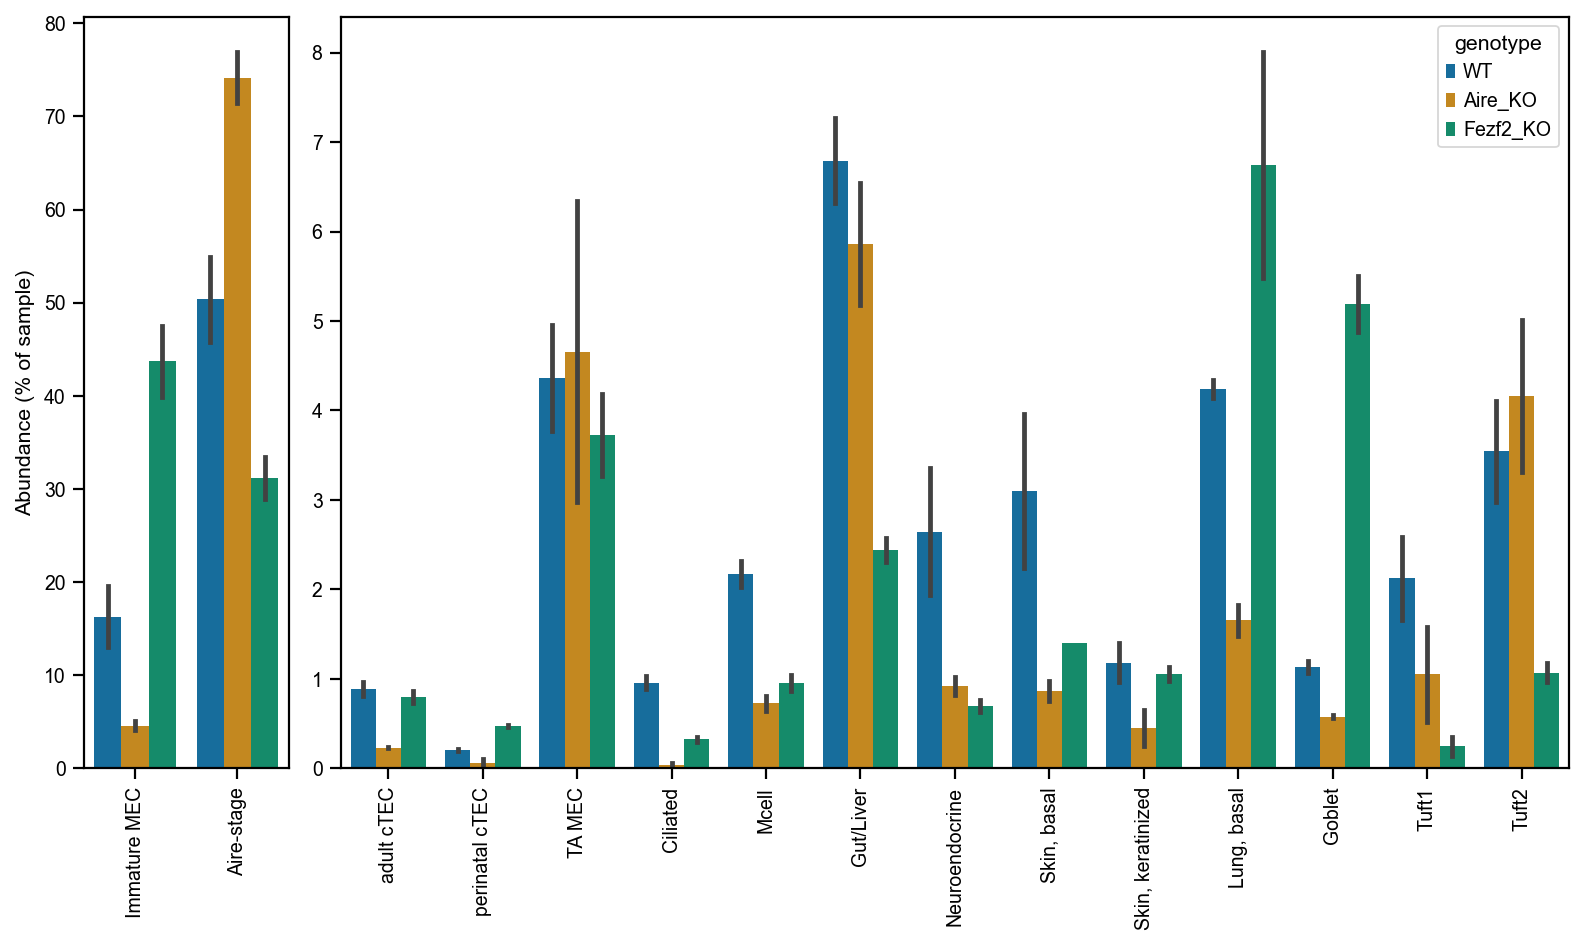

In [13]:
fig, axs = plt.subplots(1,2,figsize=(10,6), gridspec_kw={'width_ratios': [1, 6]})

sns.barplot(
    abundance_data[abundance_data.cell_type.isin(["Aire-stage", "Immature MEC"])],
    x="cell_type",
    y="abundance",
    hue="genotype",
    ax=axs[0],
    errorbar=("pi", 100),
    order = ["Immature MEC", "Aire-stage"],
    palette=cmap[0:3],
)
# for cell_type in ["Aire-stage", "Immature MEC"]:
#     sns.stripplot(
#         abundance_data[abundance_data.cell_type == cell_type],
#         x="cell_type",
#         y="abundance",
#         hue="genotype",
#         dodge=True,
#         s=5,
#         ax=axs[0],
#         legend=None,
#         palette=["black"]*3,
#         order = ["Immature MEC", "Aire-stage"],
#         jitter=False
#     )
axs[0].get_legend().remove()
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_xlabel("")
axs[0].set_ylabel("Abundance (% of sample)")
axs[0].grid(False)

sns.barplot(
    abundance_data[~abundance_data.cell_type.isin(["Aire-stage", "Immature MEC"])],
    x="cell_type",
    y="abundance",
    hue="genotype",
    ax=axs[1],
    errorbar=("pi", 100),
    order = [
        "adult cTEC", "perinatal cTEC", "TA MEC", "Ciliated", "Mcell", 
        "Gut/Liver", "Neuroendocrine", "Skin, basal", "Skin, keratinized",
        "Lung, basal", "Goblet", "Tuft1", "Tuft2"
    ],
    palette=cmap[0:3],
)
# for cell_type in abundance_data.cell_type.unique():
#     if cell_type not in ["Aire-stage", "Immature MEC"]:
#         sns.stripplot(
#             abundance_data[abundance_data.cell_type == cell_type],
#             x="cell_type",
#             y="abundance",
#             hue="genotype",
#             dodge=True,
#             s=5,
#             ax=axs[1],
#             legend=None,
#             palette=["black"]*3,
#             order = [
#                 "adult cTEC", "TA MEC", "Ciliated", "Mcell", 
#                 "Gut/Liver", "Neuroendocrine", "Skin, basal", "Skin, keratinized",
#                 "Lung, basal", "Goblet", "Tuft1", "Tuft2"
#             ],
#             jitter=False
#         )
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].grid(False)

plt.subplots_adjust(wspace=0.15)
plt.tight_layout()
plt.savefig("../analysis/paper_figures/1/1E_scRNAseq_cell_type_abundances.pdf")
plt.show()

In [14]:
pvalues = pd.DataFrame()
for cell_type in abundance_data.cell_type.unique():
    cell_type_data = abundance_data[abundance_data.cell_type == cell_type]
    WT_abundance = cell_type_data[cell_type_data.genotype == "WT"].abundance
    for genotype in "Aire_KO", "Fezf2_KO":
        KO_abundance = cell_type_data[cell_type_data.genotype == genotype].abundance
        pvalue = pd.DataFrame(
            [cell_type, genotype, ttest_ind(WT_abundance, KO_abundance).pvalue],
            index=["cell_type", "genotype", "pval"]
        ).T
        pvalues = pd.concat([pvalues, pvalue], ignore_index=True)
pvalues

,cell_type,genotype,pval
0,Aire-stage,Aire_KO,0.046131
1,Aire-stage,Fezf2_KO,0.064173
2,Immature MEC,Aire_KO,0.072504
3,Immature MEC,Fezf2_KO,0.031962
4,Gut/Liver,Aire_KO,0.37998
5,Gut/Liver,Fezf2_KO,0.012726
6,TA MEC,Aire_KO,0.883694
7,TA MEC,Fezf2_KO,0.485467
8,"Lung, basal",Aire_KO,0.006057
9,"Lung, basal",Fezf2_KO,0.186235


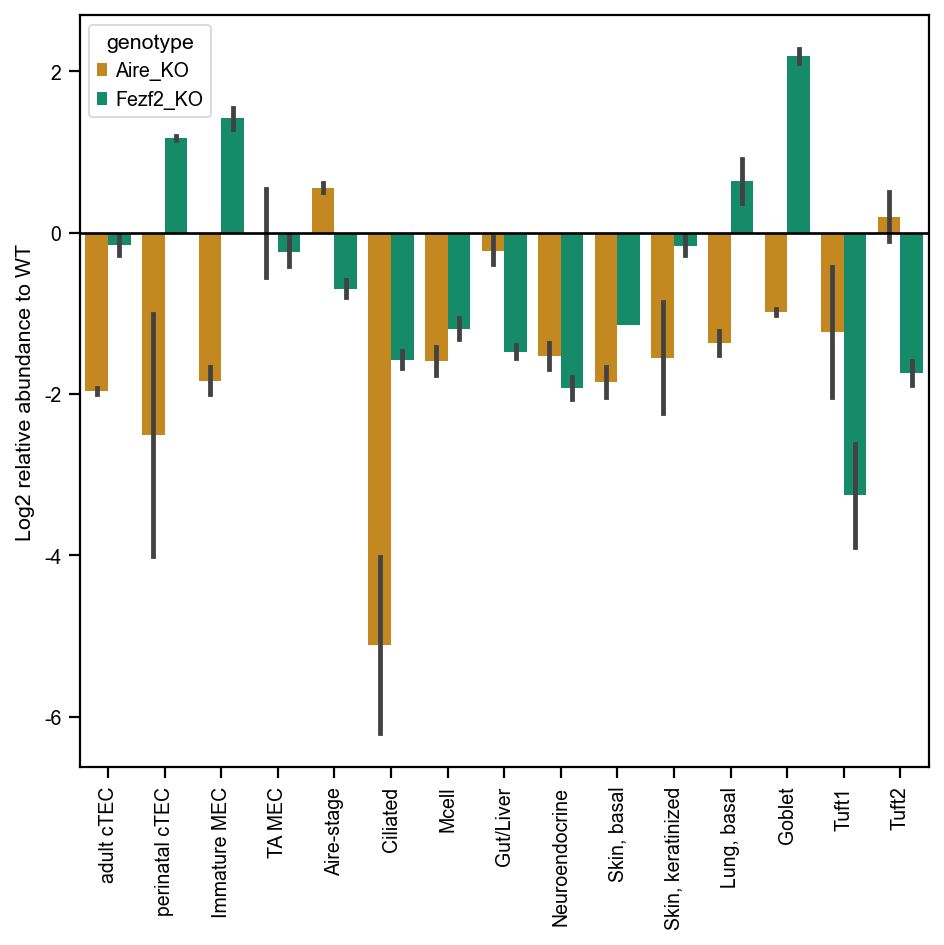

In [15]:
order = [
        "adult cTEC", "perinatal cTEC", "Immature MEC", "TA MEC", "Aire-stage", "Ciliated", "Mcell", 
        "Gut/Liver", "Neuroendocrine", "Skin, basal", "Skin, keratinized",
        "Lung, basal", "Goblet", "Tuft1", "Tuft2"
]

plt.figure(figsize=(6,6))

ax = sns.barplot(
    abundance_fc,
    x="cell_type",
    y="abundance",
    hue="genotype",
    errorbar=("pi", 100),
    order=order,
    palette=cmap[1:3]
)
# for cell_type in abundance_fc.cell_type.unique():
#     sns.stripplot(
#         abundance_fc[abundance_fc.cell_type == cell_type],
#         x="cell_type",
#         y="abundance",
#         hue="genotype",
#         dodge=True,
#         s=5,
#         legend=None,
#         palette=["black"]*2,
#         order=order,
#         jitter=False
#     )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("")
ax.set_ylabel("Log2 relative abundance to WT")
ax.grid(False)
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../analysis/paper_figures/S2/S2B_scRNAseq_cell_type_abundances.pdf")
plt.show()

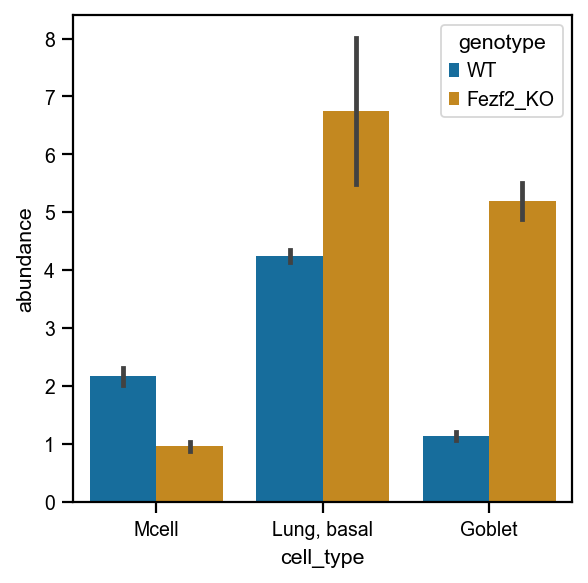

In [23]:
sns.barplot(
    abundance_data[abundance_data.cell_type.isin(["Mcell", "Lung, basal", "Goblet"]) & abundance_data.genotype.isin(["WT", "Fezf2_KO"])],
    x="cell_type",
    y="abundance",
    hue="genotype",
    errorbar=("pi", 100),
    order = ["Mcell", "Lung, basal", "Goblet"],
    palette=cmap[0:3],
)
plt.savefig("../analysis/paper_figures/S6/S6_keratinized_cell_abundances.pdf")
plt.show()
